<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint14/M4_DS_424_Deploy_Assignment_incomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# *Data Science Unit 4 Sprint 2 Assignment 4*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model.

**Don't forget to switch to GPU on Colab!**


## Objectives

In lecture, you were exposed to several regularization techniques: Lp space regularization, Max Norm weight constraints, and dropout regularization.

1: Explore the effects of these regularization techniques on model performance and on the learned model weights.

2: Review how to save a model and how to retrieve the saved model from a file.





#### Import libraries

In [3]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
# native libraries
import os
from time import time

# data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries
import tensorflow as tf
from keras import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Flatten, Dense, Dropout
from keras.layers import ReLU
from keras.initializers import GlorotUniform
from keras.utils import get_file



# regularizers
from keras.regularizers import l2, l1
from keras.constraints import max_norm

# required for compatibility between sklearn and keras
# from scikeras.wrappers import KerasClassifier - old
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# native python unit test library
from unittest import TestCase

%matplotlib inline

-----
# Part 1: GridSearch Experiments

The next set of experiments will involve gridsearching regularization parameter values.

The rest of the notebook will actually require very little coding on your part. Instead, the focus is for you to run those gridsearches and answer the questions at the end of each experiment. Those questions are designed to help you capture the insights that there are to learn from each of the experiments.

All of the following experiments are designed to help you better understand the relationship between the various regularization techniques and how they affect model performance.


### Build Model

Let's build out the model that we'll be using all throughout our experiments.

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when our models are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model.

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, use `build_complex_model`.

In this notebook, we'll use  `build_complex_model` to run our experiments.

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening.

### Load the `quickdraw10` data set
using code provided in the Module 3 assignment.

In [2]:
# YOUR CODE HERE
def load_quickdraw10():
    """
    Fill out this doc string, and comment the code, for practice in writing the kind of code that will get you hired.
    """

    URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"

    path_to_zip = get_file('./quickdraw10.npz', origin=URL_, extract=False)

    data = np.load(path_to_zip)

    # normalize your image data
    max_pixel_value = 255
    X = data['arr_0']/max_pixel_value
    Y = data['arr_1']

    return train_test_split(X, Y, shuffle=True)

In [4]:
X_train, X_test, y_train, y_test = load_quickdraw10()

25421363/25421363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
X_train.shape

(75000, 784)

In [6]:
y_train.shape

(75000,)

### Build the model

In [7]:
X_train.shape[1]

784

In [10]:
def build_complex_model(Lp_reg=None, reg_penalty=None, dropout_prob=0.0, maxnorm_wc=None):
    """
    Build and return a regularized 3 hidden layer FCFF model

    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization
        If None, that means that l1 or l2 regularization will not be used.

    reg_penalty: None or float
        If float, reg_penalty is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2


    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration.
        If this value is 0.0, that means that dropout will not be used.

    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.


    Return
    ------
    model: compiled Keras model
    """

    # specify the input size
    input_dim = X_train.shape[1]

    # specify the number of neurons in the output layer
    n_output = 10

    # if reg_type is not None, then pass in the penalty strength to whatever form of Lp space regularization this is
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penalty)
    else:
        Lp_regularizer = None

    if maxnorm_wc is not None:
        wc = max_norm(maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(100, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 3
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer
    Dense(n_output, activation="softmax")

    ])
    # compile model
    model.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resources.

In [11]:
def build_simple_model(Lp_reg=None, reg_penalty=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model

#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization
#         If None, that means that l1 or l2 regularization will not be used.

#     reg_penalty: None or float
#         If float, reg_penalty is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2


#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration.
#         If this value is 0.0, that means that dropout will not be used.

#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.


#     Return
#     ------
#     model: compiled Keras model
#     """

#    # specify the input size
    input_dim = X_train.shape[1]

#    # specify the number of neurons in the output layer
    n_output = 10

    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penalty)
    else:
        Lp_regularizer = None

    # # instantiate Sequential class
    model = Sequential([

    # # hidden layer 1
    Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # # act func 1
    ReLU(negative_slope=0.01),
    Dropout(p_dropout),

    # # output layer
    Dense(n_output, activation="softmax")

    ])
    # compile model
    model.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

    return model

Since we'll be using sklearn's `GridsearchCV` class, we need to wrap our Keras models in `KerasClassifier`

In [12]:
# wrap KerasClassifier around build_model for compatibility with sklearn GridsearchCV
model = KerasClassifier(build_fn = build_complex_model)

-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

_Note: <br>
In the right panel of the above diagram, **SSE** <br>
stands for "Sum of Squared Errors".<br>
In the left panel, **ESS** is a typo that should read **SSE**._<br>

We are going to run a gridsearch solely on the L2 regularization penalty value and see the effect this has on model performance.

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. <br><br>


In [24]:
# build out our hyperparameter dictionary
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10
    # "reg_penalty": [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    # Since we only want to test l2, provide l2 as the sole option
    # "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearch run-time is too long for you
    "epochs": [3],
    "optimizer": ['adam'],
    "batch_size": [32],
    "random_state": [42],
    "loss": ["sparse_categorical_crossentropy", "BinaryCrossentropy"]
}

In [20]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])

In [25]:
start=time()
# takes about 7 min on Colab with GPU
# Create and run Grid Search
grid = GridSearchCV(estimator=model,
                    param_grid=hyper_parameters,
                    n_jobs=-3,
                    verbose=1,
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7487 - loss: 0.8061
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8582 - loss: 0.4609
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8900 - loss: 0.3595
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7357 - loss: 0.8276
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8545 - loss: 0.4746
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8860 - loss: 0.3704
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7404 - loss: 0.8281
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8537 - loss: 0.4794
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8857 - loss: 0.3769
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Epoch 1/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.7672 - loss: 0.7565
Epoch 2/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8658 - loss: 0.4460
Epoch 3/3
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8935 - loss: 0.3534


In [26]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 4.65 mins


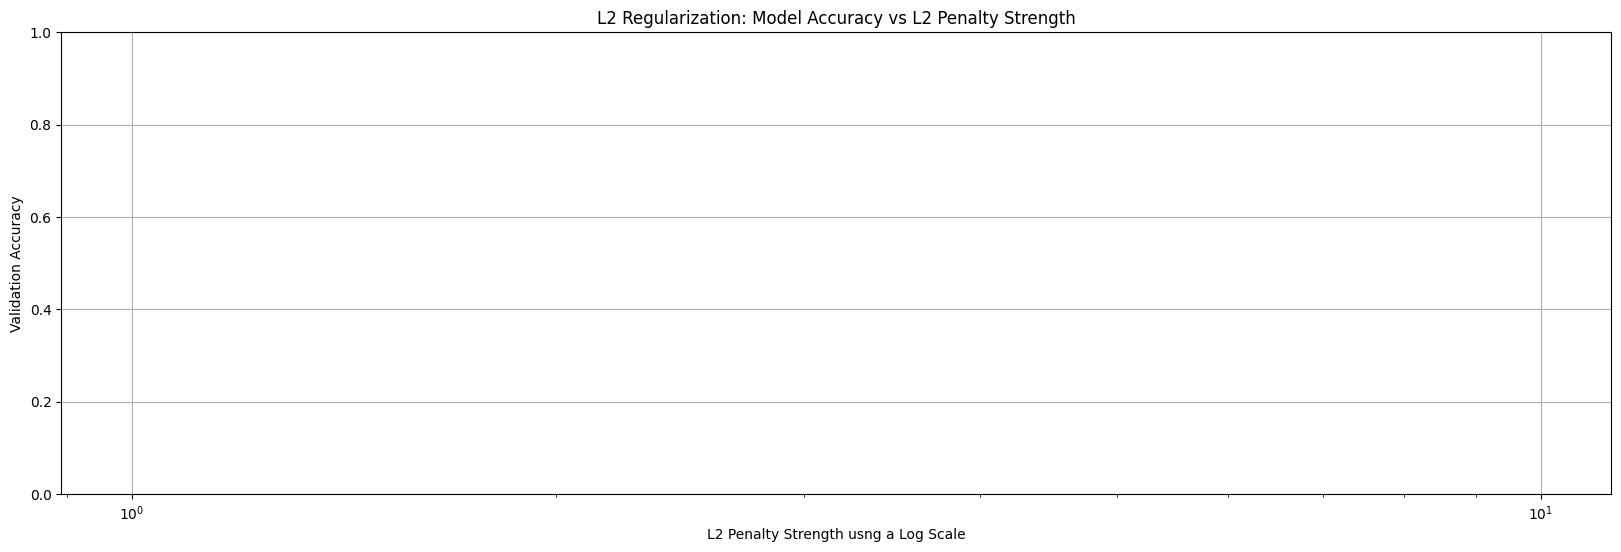

In [29]:
# use the mean accuracy from the CV splits for determining best model score
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
# param_values = [param_dict["reg_penalty"] for param_dict in params] <---- There is no more reg_penalty in the hyperparameter for KerasClassifier

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
# plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale");

### Observations

Write down some observations. What do you notice from the plot?

YOUR ANSWER HERE


## Compare Weights between the Best Model and a Worse Model

Next, we are going to compare the hidden layer weights between the best and worst performing model while taking note of the respective L2 penalty strengths.

In [30]:
# get the best l2 penalty term
best_lr_penalty = grid_result.best_params_["reg_penalty"]

# get the best trained model
#     a model that is wrapped in the KerasClassifier wrapper doesn't have a .get_weights() method.
#     So this is the workaround to generate a version of the model that does have a .get_weights() method
best_model = grid_result.best_estimator_.build_fn(Lp_reg=l2, reg_penalty=best_lr_penalty)

# get the weights from the best trained model
best_weights = best_model.get_weights()

KeyError: 'reg_penalty'

In [ ]:
# train a model using the l2_reg_penalty value that scored the lowest
worse_l2_reg_penalty = 10.0

worse_model = build_complex_model(Lp_reg=l2, reg_penalty=worse_l2_reg_penalty)

# fit model
worse_model.fit(X_train, y_train, epochs=1)

# get weights from worst performing model
worse_weights = worse_model.get_weights()

-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [ ]:
len(best_weights)

There are **weights matrices and bias vectors between each layer** and we have 5 layers. The last 4 layers are composed of neurons.

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output

So we should have a weight matrix and a bias vector from each neuron layer, <br>which accounts for $4 + 4 = 8$ elements in the list.


#### Index for Weight Matrices
If you index for a weight matrix, you can see its shape and that they are indeed matrices.

Notice how you can see the dims of the layers that the matrices are sandwiched between?

The input layer has 784 dims and hidden layer 1 has 500 neurons. <br>
So the first weight matrix should have a column of weights for each neuron; and each column has 784 weights.
Given this understanding, the numbers you see in the shapes of the weight and bias arrays should make sense.

In [31]:
# bewteen input and 1st hidden layer
best_weights[0].shape

NameError: name 'best_weights' is not defined

In [ ]:
# bewteen 1st and 2nd hidden layer
best_weights[2].shape

In [ ]:
# bewteen 2nd and 3rd hidden layer
best_weights[4].shape

In [ ]:
# bewteen 3rd hidden layer and output layer
best_weights[6].shape

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer).

In [ ]:
# for hidden layer 1
best_weights[1].shape

In [ ]:
# for hidden layer 2
best_weights[3].shape

In [ ]:
# for hidden layer 3
best_weights[5].shape

In [ ]:
# for output layer
best_weights[7].shape

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

To gauge the performance effect of L2 regularization, we'll compare the weights for the 1st hidden layer from the best and worst performing models from our hyperparameter search space, as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer.

Read the docs to figure out how to get the weights from a Keras dense layer.
Also have a look at this helpful post on StackOverflow: [**How to view initialized weights (i.e. before training)?**](https://stackoverflow.com/questions/46798708/how-to-view-initialized-weights-i-e-before-training)


Before we compare weights, let's take note of the following.

Both `best_weights[0]` or `worse_weights[0]` are matrices with shape `(784, 500)`.

If we flatten them, then we get `784 * 500 = 392000` weights. What does this mean exactly?

Remember that we are working with the Fully Connected Feed-Forward model which looks something like this.

![](https://pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg)

In Fully Connected neural network models, the outputs from a layer become the inputs for the next layer. Each output from a layer is passed as an input to all the nodes in next layer.<br>
Our input layer has $784$ output weights which are the pixel values in the image. Each neuron (or node) in hidden layer $1$ also has $784$ weights, one for each pixel input.  Hidden layer 1 has $500$ neurons. So the weights are conveniently represented as a **weights matrix** with $784$ rows (one row for each pixel in the input image) and $500$ columns (one column for each neuron in the layer). The $i$th column of the weights matrix holds the $784$ weights $\textbf{w}_{i}$ belonging to the $i$th neuron in the layer.

To keep our analysis simple, we are going to analyze only the weights corresponding to the first neuron in hidden layer $1$, whose weights $\textbf{w}_{1}$ are the first column of the weight matrix.  <br><br>

We will observe the effect of L2 regularization on neuron 1 in hidden layer 1.


In [ ]:
# index for the 1st column (784 entries) in the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st column (784 entries) in the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights
# instantiate GlorotUniform and sample 784 weights and save to initial_weight_values

# Build a data frame with these 3 vectors as columns

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# move all weights to a dataframe for ease of analysis
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols

In [ ]:
# check out the statistics for each weight column
df.describe()

In [ ]:
# plot the distributions for each weight column
df.hist(figsize=(20,12));

## Observations

Take a look at the statistical table and the plots. Then answer the following questions.

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE

**What was the effect of using a small L2 penalty value (regularization constant)?**

YOUR ANSWER HERE

**What was the effect of using a large L2 penalty value?**

YOUR ANSWER HERE

**Given what you know about L2 regularization, are you surprised by these results?**

YOUR ANSWER HERE

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **norm** of a vector is another word for the **length** of the vector.

`MaxNorm` weight constraint puts a limit on the norm of the weight vector.

The effect that Lp regularization and `MaxNorm` regularization have on the weights is similar, but they go about it in different ways.

While Lp regularization (L1/Lasso and L2/Ridge) shrink the weight values by imposing constraints on their L1 and L2 norms, `MaxNorm` regularization shrinks the weight values by imposing a limit on the norm of a weight vector. Here's how it works: if an update would push the norm of a weight vector above MaxNorm, a scale factor is applied to all the weights so as to shrink the norm back to MaxNorm.

In this experiment, we'll run another gridseach, similar to the one we ran for L2 regularization in the previous experiment. This time, we are going to gauge the effect of `MaxNorm` regularization on model performance and the distribution of the learned weights. As in the previous experiment, we will simplify our analysis by focusing on the weights for the first neuron in the first hidden layer.

Since we already built our model, we just need to update the `hyper_parameters` dictionary.

In [ ]:
# build out our hyperparameter dictionary
hyper_parameters = {

    "maxnorm_wc": np.linspace(0.5, 10.0, num=20),
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you
    "epochs": [1]
}

hyper_parameters

In [ ]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model,
                    param_grid=hyper_parameters,
                    n_jobs=-2,
                    verbose=1,
                    cv3)

grid_result = grid.fit(X_train, y_train)
end=time()

In [ ]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

In [ ]:
# use the mean accuracy from the CV splits for determining best model score
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["maxnorm_wc"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("MaxNorm weight constraint: Model Accuracy vs MaxNorm")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [ ]:
# get the best value of max norm from grid and save to best_max_norm_val

# get the best trained model from grid and save to best_model

# get the weights from the best trained model and save to best_weights

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
best_max_norm_val

In [ ]:
# we can verify that the norm of our weights are indeed below the maximum allowed value
np.linalg.norm(best_weights[0][0])

In [ ]:
# train a model using the max_norm_val value that scored the lowest

# build a model using build_complex_model and worse_max_norm_val and save it to worse_model

# fit model

# get weights from worse performing model


# YOUR CODE HERE
raise NotImplementedError()

Sample the initial weights from the `Glorot Uniform Weight Initializer`, for comparison

In [ ]:
# index for the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights

# instantiate GlorotUniform and sample 500 weights and save to initial_weight_values
# hint: use shape=(1, 500)


# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# move all weights to a dataframe for ease of analysis
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [ ]:
df_maxnorm.describe()

In [ ]:
# plot the distributions for each weight column
df_maxnorm.hist(figsize=(20,12));

## Observations

Take a look at the statistical table and the plots. Then answer the following questions.

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

YOUR ANSWER HERE

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

YOUR ANSWER HERE

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

YOUR ANSWER HERE

**Given what you know about MaxNorm regularization, are you surprised by these results?**

YOUR ANSWER HERE

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd experiment, we will use gridsearch to see how varying the value of the the dropout probability affects model performance.

Recall from lecture that dropout tends to perform best when used with `MaxNorm` regularization. Since this is the case, we will gridsearch both dropout probability and the weight constraint for `MaxNorm`.

If interested, feel free to read (or just skim) through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

**Key Take aways:**

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in.
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [ ]:
# build out our hyperparameter dictionary
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=5),
    # take note that l1_reg_penalty values are in powers of 10
    "dropout_prob": np.linspace(0.0, 0.6, num=5),
    "epochs": [1] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

In [ ]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model,
                    param_grid=hyper_parameters,
                    n_jobs=-2,
                    verbose=1,
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

In [ ]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

In [ ]:
# use the mean accuracy from the CV splits for determining best model score
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

Since there are 2 independent hyperparameters which affect the validation accuracy (`dropout_prob` and `maxnorm_wc`), <br>
we need a two-dimensional plot. A heat map will work.

In [ ]:
dropout_prob_list = [  param_dict["dropout_prob"]  for param_dict in params]
maxnorm_wc_list = [  param_dict["maxnorm_wc"]  for param_dict in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preparation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")

In [ ]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax);

### Observations

We can see the dropout probabilities in the horizontal axis and the `MaxNorm` weight constraint values in the vertical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others.

**What range of dropout probability values tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**When taken together, what combinations of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

YOUR ANSWER HERE

**Do you think that using dropout was helpful in increasing model performance?**

YOUR ANSWER HERE

_____

#Part 2: Model Deployment
# Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models

For this experiment, review the section on Saving and Loading models from the guided project, then:

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to a file
- Load the trained model from the file
- Just as we did in the Guided Project, evaluate the loaded model using a test set and verify that the results of the loaded model match that of the original model that was saved.

In [ ]:
# YOUR CODE HERE
